Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import percentileofscore, norm

Info

In [2]:
def important_info(asset):
    print(f"                           {asset.info["underlyingSymbol"]}\n")
    print(f"Bid Price: {asset.info["bid"]}{asset.info["currency"]}         |        Ask Price: {asset.info["ask"]}{asset.info["currency"]}")
    print(f"Day Low: {asset.info["dayLow"]}{asset.info["currency"]}           |        Day High: {asset.info["dayHigh"]}{asset.info["currency"]}")
    print(f"TTM Low: {asset.info["fiftyTwoWeekLow"]}{asset.info["currency"]}           |        TTM High: {asset.info["fiftyTwoWeekHigh"]}{asset.info["currency"]}\n")
    print(f"                    Day Open: {asset.info["open"]}{asset.info["currency"]}")
    

crude_oil=yf.Ticker("CL=F")
important_info(crude_oil)

                           CL=F

Bid Price: 70.54USD         |        Ask Price: 70.59USD
Day Low: 70.52USD           |        Day High: 72.02USD
TTM Low: 65.27USD           |        TTM High: 87.67USD

                    Day Open: 71.52USD


Preprocessing

[*********************100%%**********************]  1 of 1 completed


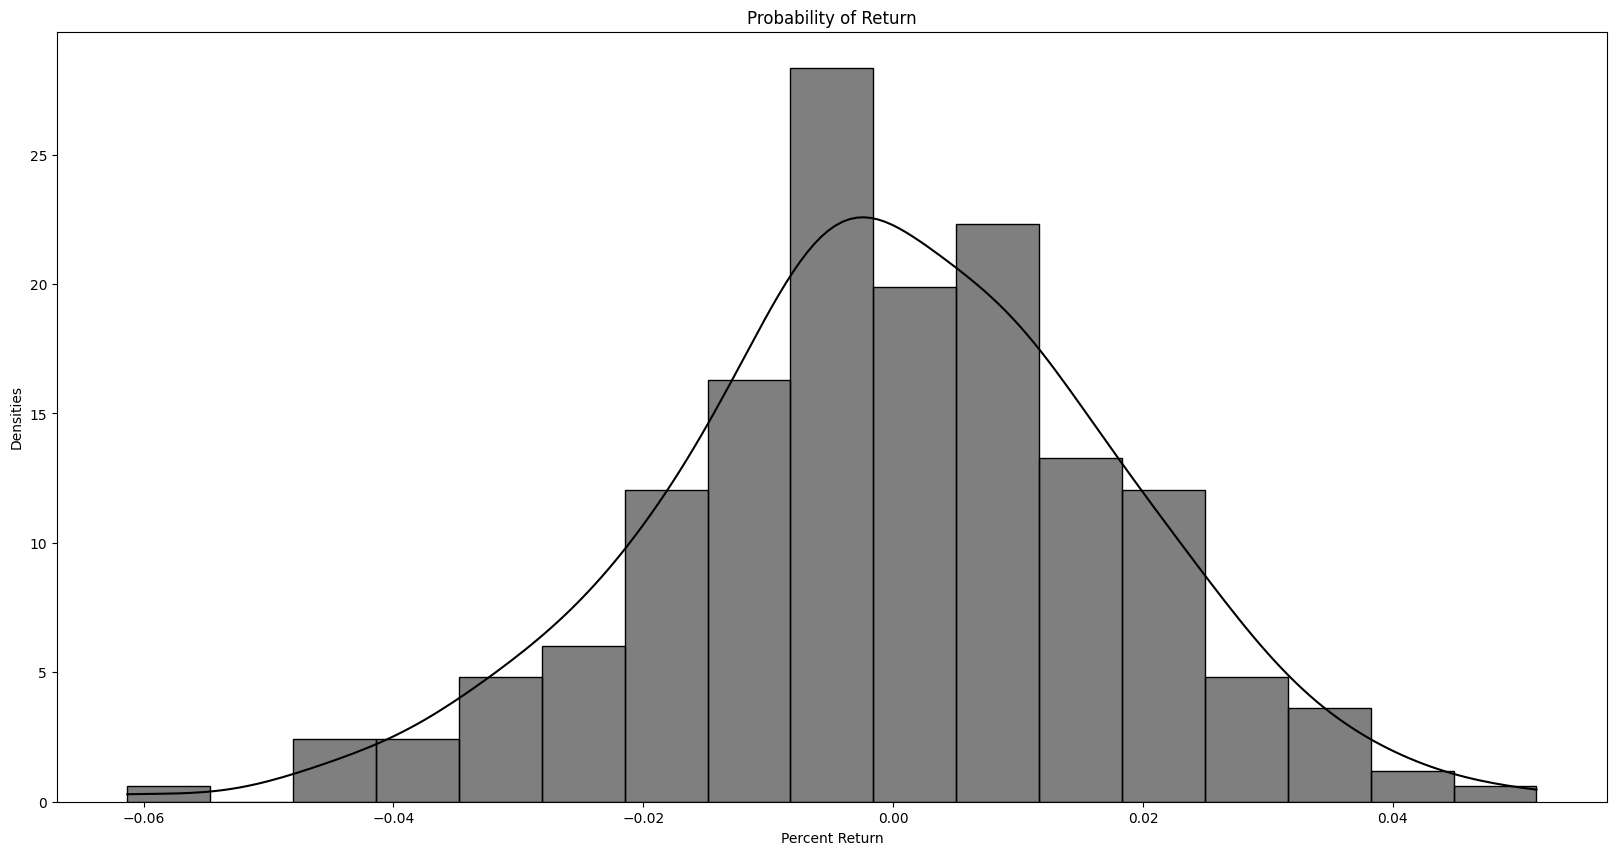

In [3]:
gold_data=yf.download("CL=F", period="1Y")["Adj Close"]
gold_data_daily_returns=gold_data.pct_change().dropna() #Daily Returns
plt.figure(figsize=(20,10))
plt.xlabel("Percent Return")
plt.ylabel("Densities")
plt.title("Probability of Return")
sns.histplot(gold_data_daily_returns,stat="density",kde=True,color="black")
plt.show()


VaR Testing (Historical Data Method)

In [38]:
sorted_returns=gold_data_daily_returns.sort_values(ascending=True)
probabilities=[0.01,0.05,0.1]
daily_returns=[-0.04,-0.03,-0.02,-0.01]
print("HISTORICAL DATA METHOD\n")
for prob in probabilities:
    print(f"There is a {prob*100:.0f}% probability of exceeding a daily loss of {np.percentile(sorted_returns,prob*100)*100:.4f}%")
print()
for daily_return in daily_returns:
    print(f"The probability of excedding a daily loss of {daily_return*100:.0f}% is {percentileofscore(sorted_returns,daily_return):.2f}%")


HISTORICAL DATA METHOD

There is a 1% probability of exceeding a daily loss of -4.3836%
There is a 5% probability of exceeding a daily loss of -3.1194%
There is a 10% probability of exceeding a daily loss of -2.2903%

The probability of excedding a daily loss of -4% is 2.00%
The probability of excedding a daily loss of -3% is 5.60%
The probability of excedding a daily loss of -2% is 13.60%
The probability of excedding a daily loss of -1% is 26.80%


Conditional Value at Risk

In this case, we disregard the probabilities of the losses beyond the threshold. Therefore, an improvement can be made later with considering the probabilities.

In [5]:
var=0.05
return_at_percentile=np.percentile(sorted_returns,var*100)
returns_below_var=sorted_returns[sorted_returns<return_at_percentile]
c_var=returns_below_var.mean()
print(f"The expected daily loss beyond VaR of {var*100:.0f}% is {c_var*100:.2f}%")

The expected daily loss beyond VaR of 5% is -3.93%


Conditional Value at Risk (Parametric Method)

We will assume a normal distribution of daily returns considering the histplot we have plotted.

In [ ]:
mean,std=norm.fit(sorted_returns)
print(f"Mean: {mean*100:.6f}%, Standard Deviation: {std*100:.5f}%")
var_95=norm.ppf(var,loc=mean,scale=std)
print(f"95% Value at Risk: {var_95*100:.4f}%")
cvar= 1 / var * norm.expect(lambda x : x,lb=-np.inf, ub=var_95,loc=mean,scale=std)
print(f"Conditional Value at Risk below {cvar*100:.3f}%")

Mean:-0.030033%, Standard Deviation:1.78946%
95% Value at Risk: -2.9734%
Conditional Value at Risk below -3.721%


VaR (Monte Carlo Method)

In [12]:
simulations=10000
simulated_returns=np.random.choice(sorted_returns,size=simulations)
mc_sorted_returns=np.sort(simulated_returns)
mc_sorted_returns

array([-0.06129843, -0.06129843, -0.06129843, ...,  0.05149787,
        0.05149787,  0.05149787])

<Axes: title={'center': 'MC Simulated Daily Return Density Plot'}, xlabel='Daily Return', ylabel='Density'>

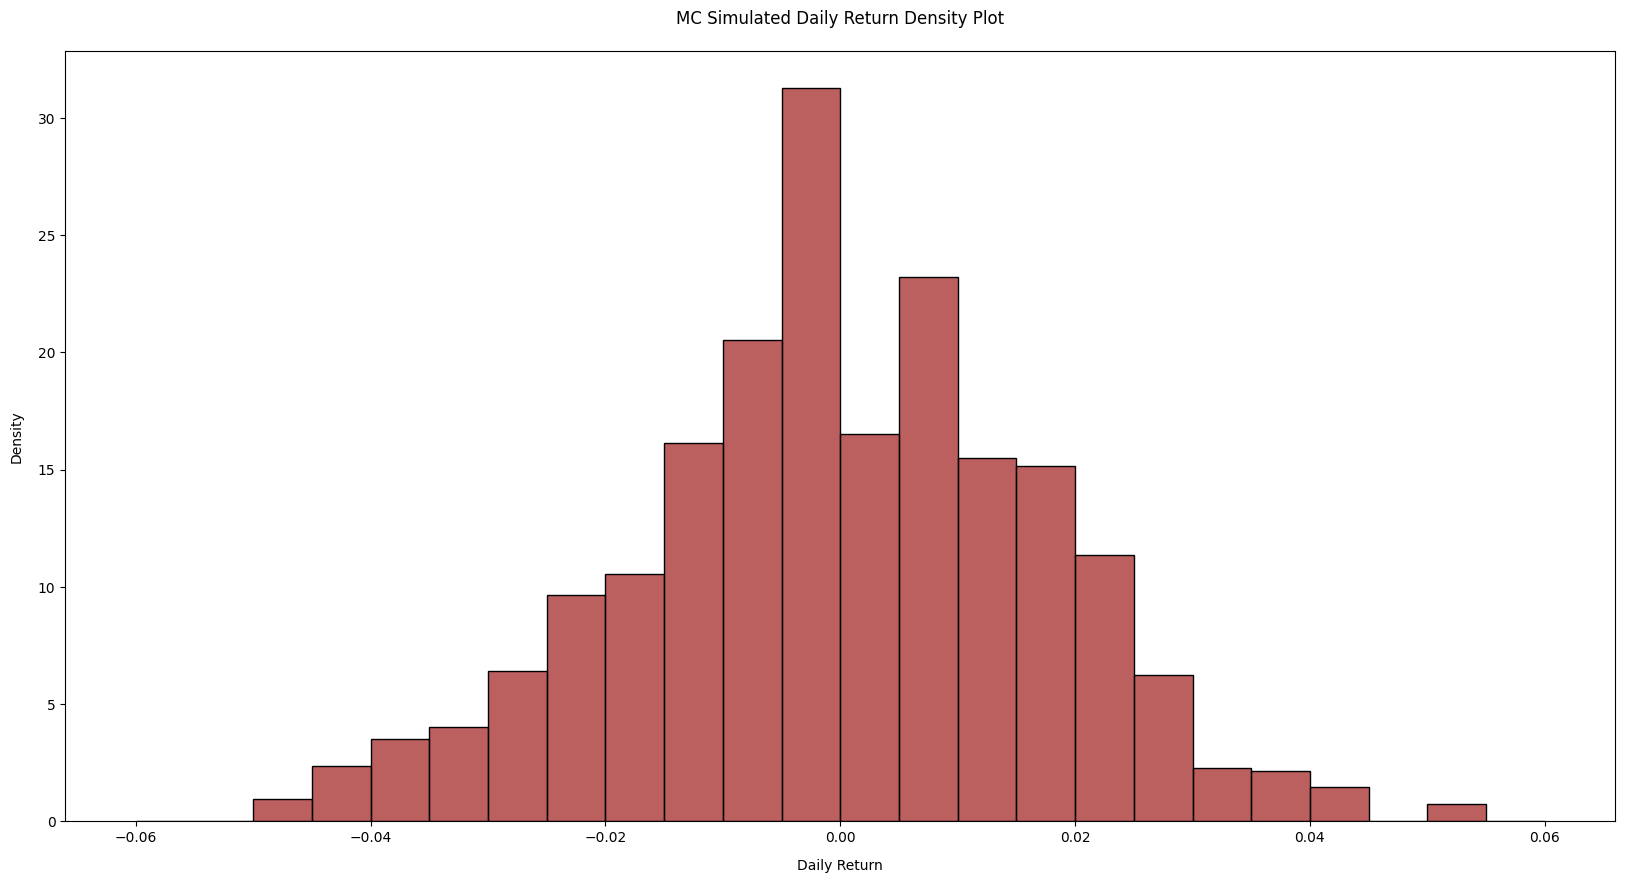

In [36]:
plt.figure(figsize=(20,10))
plt.title("MC Simulated Daily Return Density Plot",pad=20)
plt.xlabel("Daily Return",labelpad=10)
plt.ylabel("Density",labelpad=10)
sns.histplot(mc_sorted_returns,color="brown",stat="density",bins=np.linspace(-0.06,0.06,25))

In [39]:
print("MONTE CARLO METHOD\n")
for probability in probabilities:
    print(f"There is a {probability*100:.0f}% probability of exceeding a daily loss of {np.percentile(mc_sorted_returns,probability*100)*100:.4f}%")
print()
for daily_return in daily_returns:
    print(f"The probability of exceeding a daily loss of {daily_return*100:.0f}% is {percentileofscore(mc_sorted_returns,daily_return):.2f}%")



MONTE CARLO METHOD

There is a 1% probability of exceeding a daily loss of -4.4020%
There is a 5% probability of exceeding a daily loss of -3.1279%
There is a 10% probability of exceeding a daily loss of -2.2971%

The probability of exceeding a daily loss of -4% is 1.98%
The probability of exceeding a daily loss of -3% is 5.73%
The probability of exceeding a daily loss of -2% is 13.73%
The probability of exceeding a daily loss of -1% is 27.02%
